In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3,4" # specify which GPU(s) to be used
bm.disable_gpu_memory_preallocation()
bm.set_platform('gpu')

/home/spirit/anaconda3/envs/slca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Izh(bp.NeuGroupNS):
    def __init__(self, size, a=0.02, b=-0.1, c=-55.0, d= 6.0, V_th=30., method='rk2', **kwargs):
        super(Izh, self).__init__(size=size, **kwargs)
        # parameters
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.V_th = V_th
        
        # 初始化变量
        self.V = bm.Variable(bm.zeros(self.num) - 65.)  # 膜电位
        self.u = bm.Variable(self.V * b)  # u变量
        self.input = bm.Variable(bm.zeros(self.num))  # 外界输入
        self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))  # 脉冲发放状态
        
        # 定义积分器
        self.integral = bp.odeint(f=self.derivative, method=method)
            
    def dV(self, V, t, u, Iext):
        return 0.04 * V * V + 5 * V + 140 - u + Iext * 100
    
    def du(self, u, t, V):
        return self.a * (self.b * V - u)
    
    # 将两个微分方程联合为一个，以便同时积分
    @property
    def derivative(self):
        return bp.JointEq([self.dV, self.du])

    def update(self):
        _t = bp.share.load('t')
        _dt = bp.share.load('dt')
        V, u = self.integral(self.V, self.u, _t, self.input, dt=_dt)  # 更新变量V, u
        spike = V > self.V_th  # 将大于阈值的神经元标记为发放了脉冲
        self.spike.value = spike  # 更新神经元脉冲发放状态
        self.V.value = bm.where(spike, self.c, V)  # 将发放了脉冲的神经元的V置为c，其余不变
        self.u.value = bm.where(spike, u + self.d, u)  # 将发放了脉冲的神经元的u增加d，其余不变
        self.input[:] = 0.  # 重置外界输入


In [3]:
class Izh_Scale(bp.NeuGroupNS):
    def __init__(self, size, a=0.02, b=-0.1, c=-55.0, d= 6.0, V_th=30., method='rk2', **kwargs):
        super(Izh_Scale, self).__init__(size=size, **kwargs)
        # parameters
        self.a = a * 5
        self.b = b
        self.c = c
        self.d = d
        self.V_th = V_th
        
        # 初始化变量
        self.V = bm.Variable(bm.zeros(self.num) - 65.)  # 膜电位
        self.u = bm.Variable(self.V * b)  # u变量
        self.input = bm.Variable(bm.zeros(self.num))  # 外界输入
        self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))  # 脉冲发放状态
        
        # 定义积分器
        self.integral = bp.odeint(f=self.derivative, method=method)
            
    def dV(self, V, t, u, Iext):
        return  (0.04 * 25 *V * V + 25 * V + 140 - u + Iext * 20) * 5
    
    def du(self, u, t, V):
        return self.a * (self.b * V - u)
    
    # 将两个微分方程联合为一个，以便同时积分
    @property
    def derivative(self):
        return bp.JointEq([self.dV, self.du])

    def update(self):
        _t = bp.share.load('t')
        _dt = bp.share.load('dt')
        V, u = self.integral(self.V, self.u, _t, self.input, dt=_dt)  # 更新变量V, u
        spike = V > self.V_th  # 将大于阈值的神经元标记为发放了脉冲
        self.spike.value = spike  # 更新神经元脉冲发放状态
        self.V.value = bm.where(spike, self.c, V)  # 将发放了脉冲的神经元的V置为c，其余不变
        self.u.value = bm.where(spike, u + self.d, u)  # 将发放了脉冲的神经元的u增加d，其余不变
        self.input[:] = 0.  # 重置外界输入

In [10]:
simulation_number = 400
# pars = dict(a = 0.02 , b= 0.2, c=-65, d=8, method='rk2') 
pars = dict(a = 0.02 , b= -0.1, c=-55.0, d=6.0, method='rk2') 
# model = bp.neurons.Izhikevich(simulation_number,**pars)
model = Izh(simulation_number,**pars)
input_current = bm.linspace(0.,10.,simulation_number)
I_ext_list    = np.array(input_current)
runner = bp.dyn.DSRunner(model, monitors=['spike','V'], inputs=['input',input_current],dt=0.01)
runner.run(1000.)
spike_sum = runner.mon['spike'].sum(axis=0) 

Predict 100000 steps: : 100%|██████████| 100000/100000 [00:58<00:00, 1714.93it/s]


In [11]:
print(spike_sum)

[   0    0    0    0    0    0    0    0    0    0   13   21   29   37
   46   54   66   75   83   91   99  107  115  124  133  141  151  160
  170  179  188  197  207  215  224  233  241  250  258  267  275  284
  292  300  309  317  325  334  342  350  359  367  375  383  391  400
  408  416  424  432  440  448  456  464  472  480  488  496  504  512
  520  528  536  544  552  560  568  575  583  591  599  607  615  622
  630  638  646  654  661  669  677  685  692  700  708  715  723  731
  738  746  754  761  769  777  784  792  799  807  814  822  830  837
  845  853  860  867  874  882  890  897  905  913  920  928  935  942
  950  957  964  972  980  987  994 1001 1010 1017 1024 1031 1039 1046
 1054 1061 1069 1076 1083 1091 1098 1106 1113 1119 1128 1135 1143 1149
 1156 1164 1171 1179 1186 1194 1200 1209 1215 1223 1230 1238 1244 1253
 1259 1267 1273 1282 1288 1296 1302 1310 1316 1324 1333 1338 1347 1352
 1361 1368 1375 1383 1388 1397 1405 1410 1419 1424 1432 1441 1446 1454
 1463 

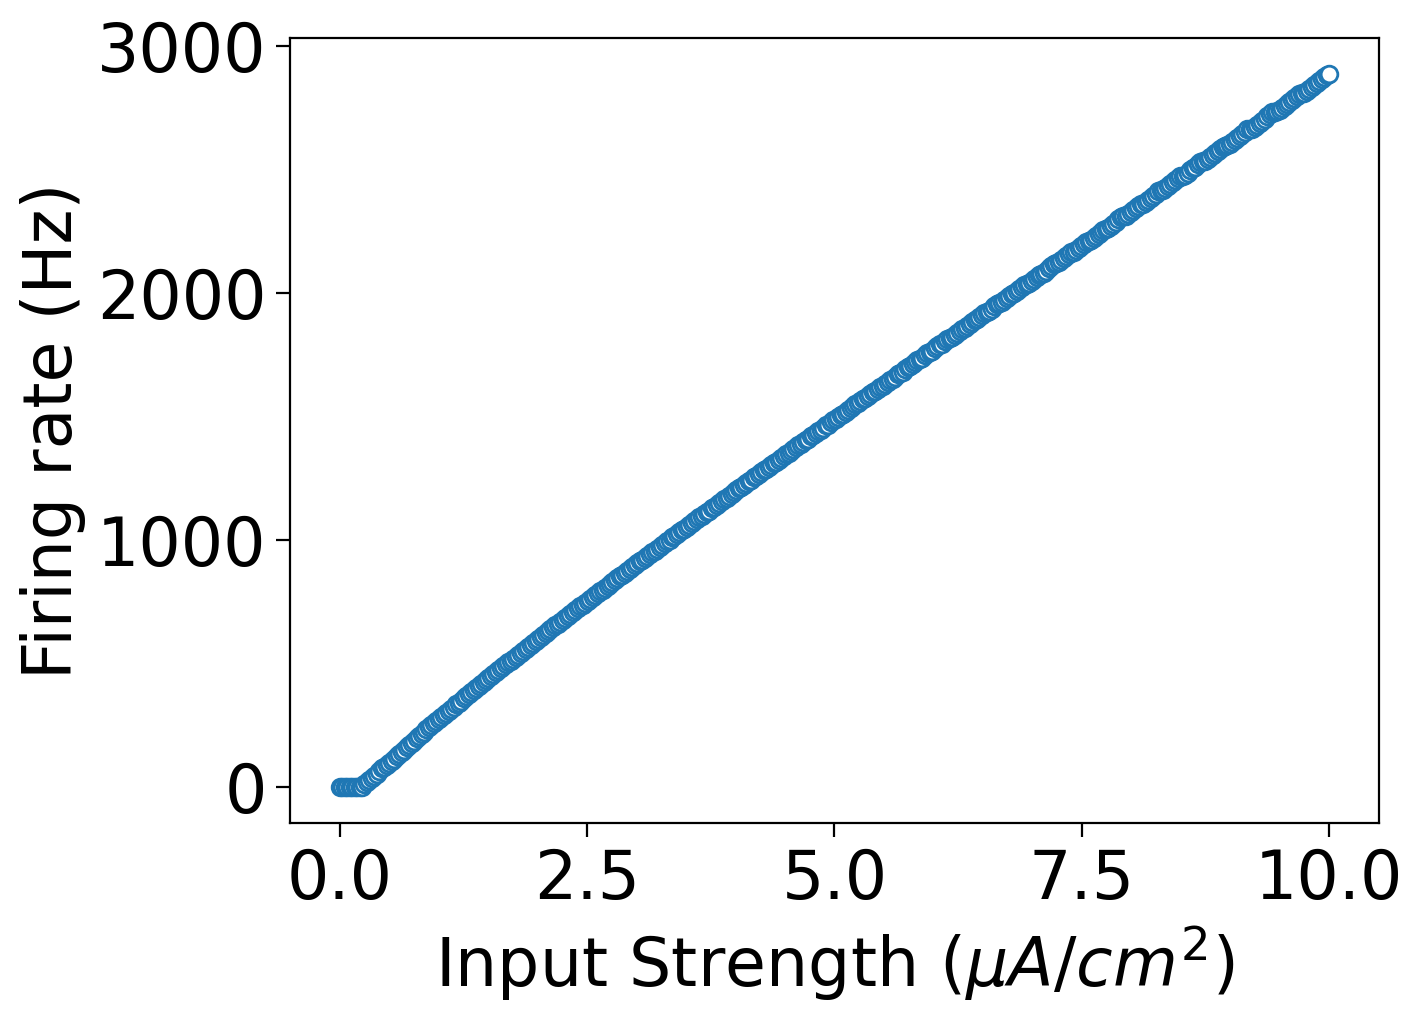

In [12]:
import matplotlib.pyplot as plt
plt_style = {
    'figure.autolayout' : True,
    'font.size' : 24,
    'lines.linewidth' : 2,
    # 'xtick.labelsize' : 'medium',
    # 'ytick.labelsize' : 'medium',
        'xtick.labelsize' : 'medium',
    'ytick.labelsize' : 'medium',
    'legend.fontsize' : 'medium',
    'axes.spines.top' : True,
    'axes.spines.right' : True,
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'legend.fontsize' : 24,
    'axes.labelsize' : 24,
    'axes.titlesize' : 24,
    }
for key, val in plt_style.items():
    plt.rcParams[key] = val

firing_rate_list = spike_sum

#paint
fig, gs = bp.visualize.get_figure(1, 1, 5, 7)
firing_rate_list = bm.array(firing_rate_list)
# firing_rate_list[firing_rate_list < 10] =0
plt.plot(I_ext_list, firing_rate_list, marker = "o", markerfacecolor = 'white',linewidth =1)
plt.xlabel(r'Input Strength ($\mu A/cm^2$)')
plt.ylabel('Firing rate (Hz)')
# plt.xlim(I_ext_list[0]-0.1, I_ext_list[-1]+0.1)
# plt.ylim([-5,100])
# plt.xlim(0, 30)
plt.show()

0.25062656
[-0.0471247   0.32773097  2.83983869  0.20385288]


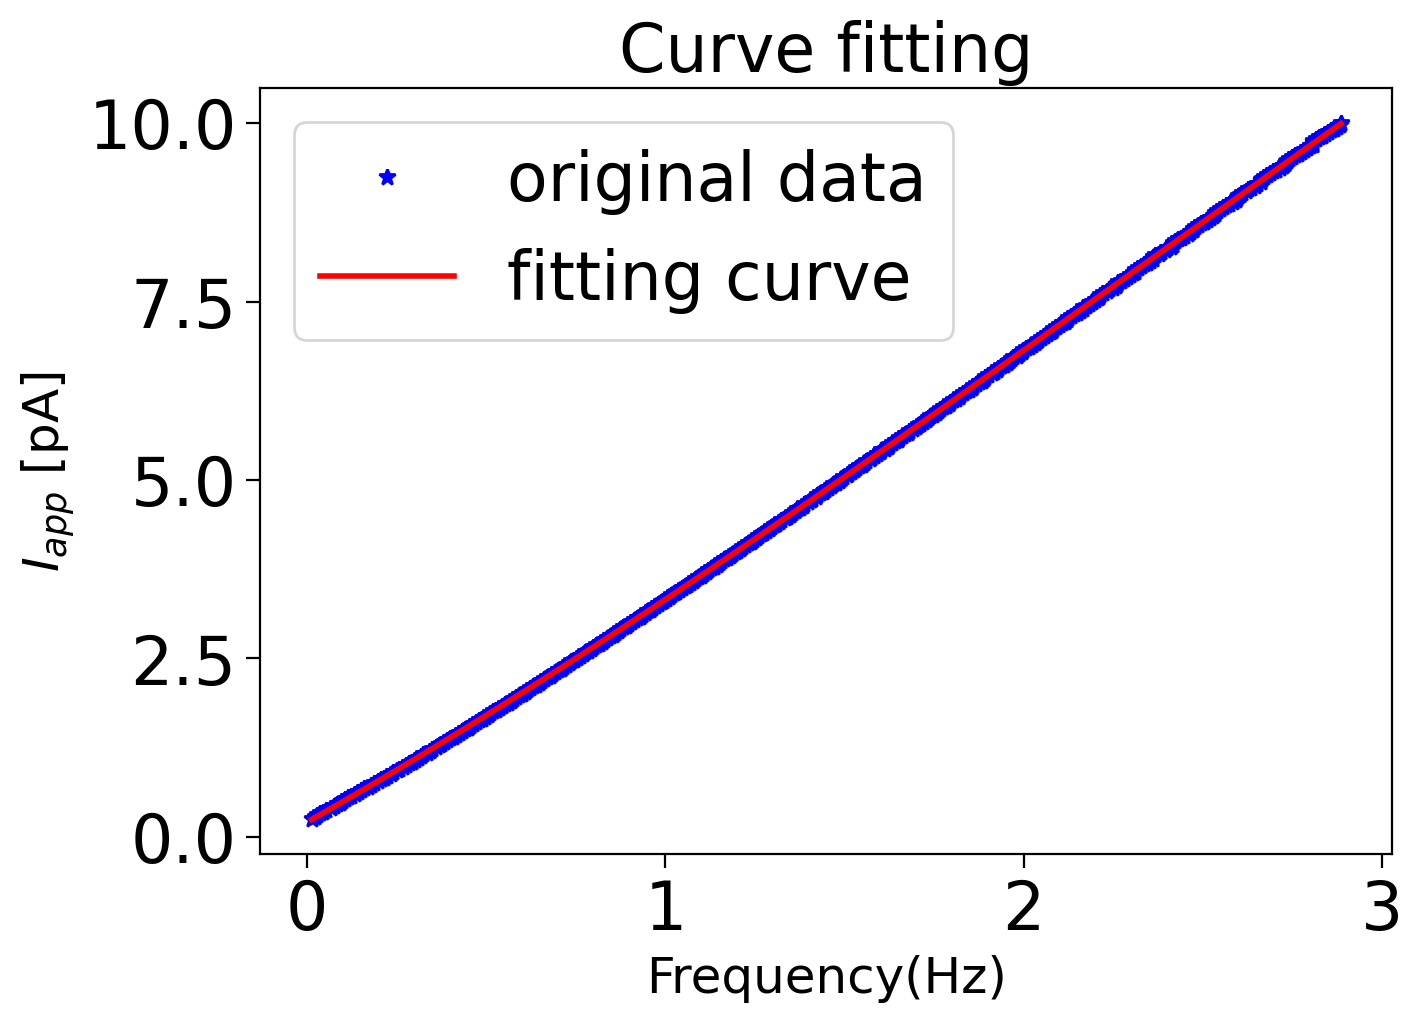

In [16]:

y = I_ext_list[firing_rate_list>0]
x = firing_rate_list[firing_rate_list>0]/1000
print(y[0])

coefficients = np.polyfit(x, y, deg=3)  # 2表示二次多项式
poly = np.poly1d(coefficients)

# 生成拟合曲线上的点
y_fit = poly(x)
print(coefficients)
fig, gs = bp.visualize.get_figure(1, 1, 5, 7)
# 绘制拟合曲线和原始数据
plt.plot(x, y,'b*',label='original data')
plt.plot(x, y_fit,'r',label='fitting curve')
plt.ylabel('$I_{app}$ [pA]', fontsize=18)
plt.xlabel('Frequency(Hz)', fontsize=18)
plt.title('Curve fitting')
plt.legend()
plt.show()



In [17]:
print(poly)


          3          2
-0.04712 x + 0.3277 x + 2.84 x + 0.2039


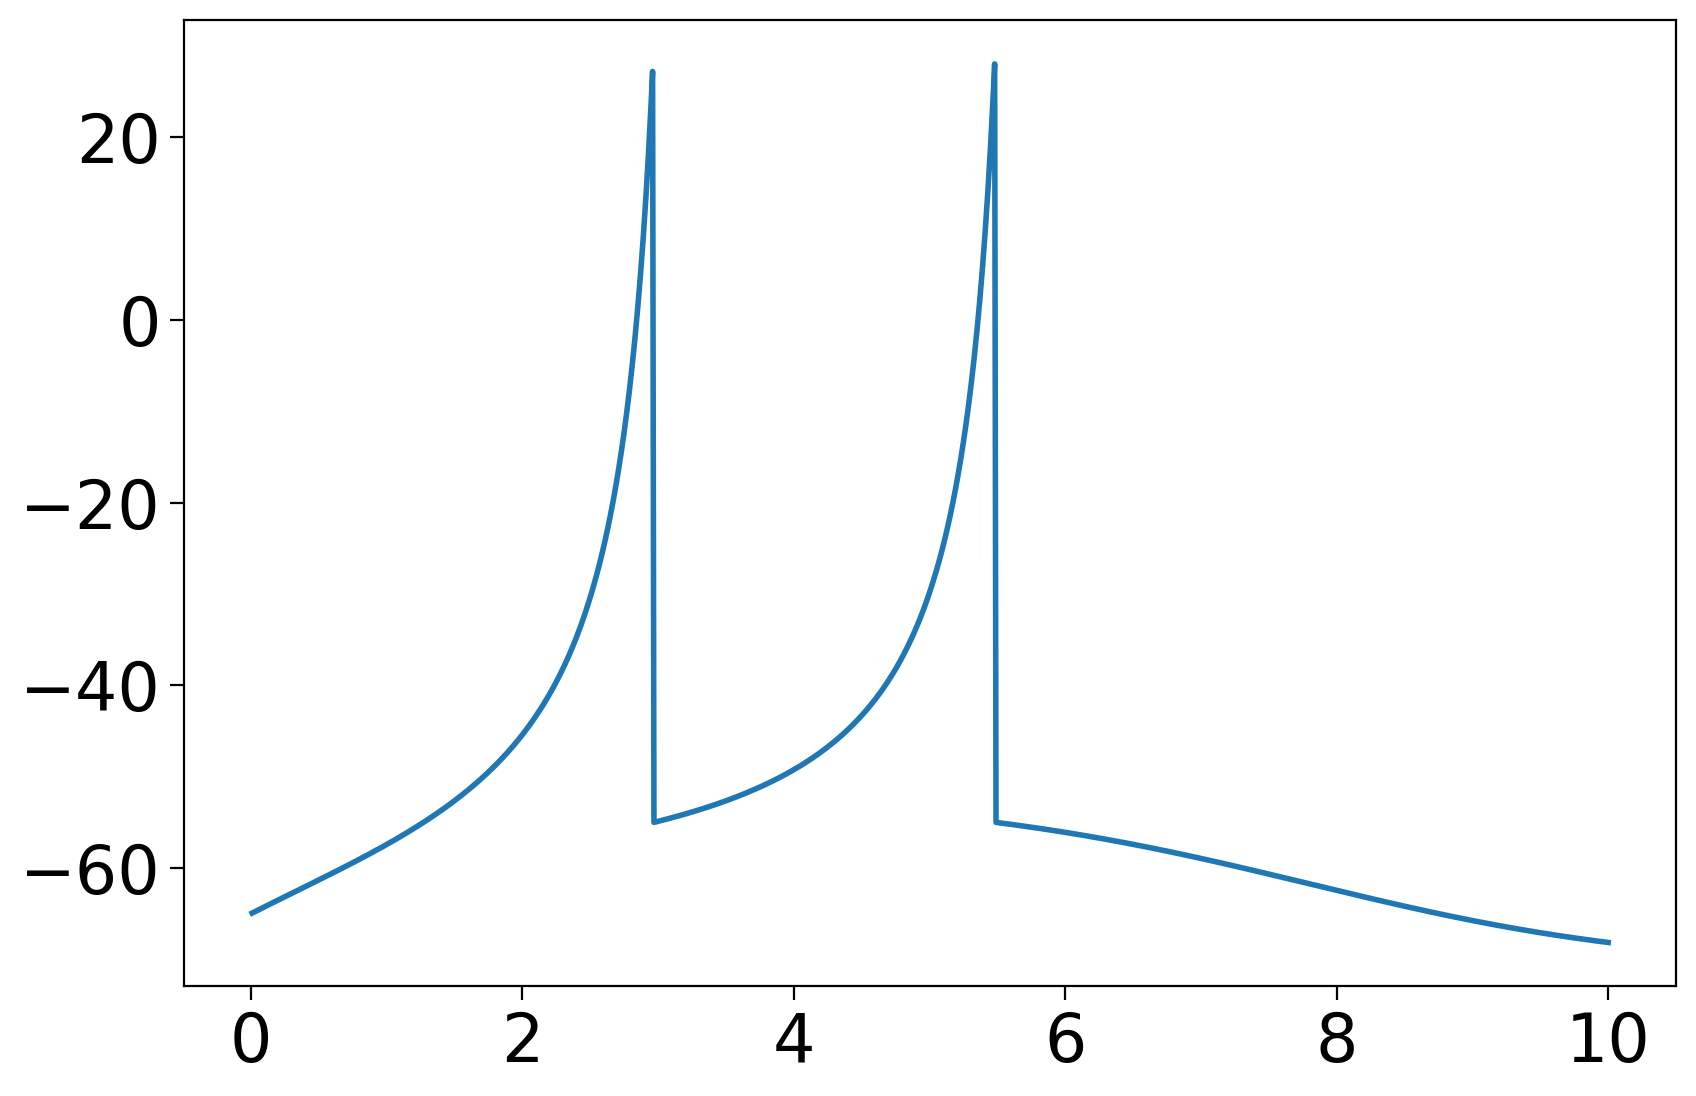

In [15]:
plt.plot(runner.mon.ts[:1000],runner.mon['V'][:1000,12])